In [8]:
#DengAI: Predicting Disease Spread

In [1]:
import re
import time
import datetime 
import operator
import numpy as np
import pandas as pd 
import collections
import unicodedata
import collections
import seaborn as sns
import collections
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import Counter
from datetime import datetime, date, timedelta
from IPython.display import Image
%matplotlib inline

In [2]:
#Data reading
#Load train and test csv file
dengue_features_train = pd.read_csv('dengue_features_train.csv')
dengue_features_test = pd.read_csv('dengue_features_test.csv')
dengue_labels_train = pd.read_csv('dengue_labels_train.csv')

In [3]:
#Display the train data
dengue_features_train.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [4]:
dengue_features_train.describe()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
count,1456.000000,1456.000000,1262.000000,1404.000000,1434.000000,1434.000000,1443.000000,1446.000000,1446.000000,1446.000000,...,1446.000000,1446.000000,1443.000000,1446.000000,1446.000000,1413.000000,1413.000000,1436.000000,1442.000000,1434.000000
mean,2001.031593,26.503434,0.142294,0.130553,0.203783,0.202305,45.760388,298.701852,299.225578,295.246356,...,40.151819,82.161959,45.760388,16.746427,4.903754,27.185783,8.059328,32.452437,22.102150,39.326360
std,5.408314,15.019437,0.140531,0.119999,0.073860,0.083903,43.715537,1.362420,1.261715,1.527810,...,43.434399,7.153897,43.715537,1.542494,3.546445,1.292347,2.128568,1.959318,1.574066,47.455314
min,1990.000000,1.000000,-0.406250,-0.456100,-0.015533,-0.063457,0.000000,294.635714,294.892857,289.642857,...,0.000000,57.787143,0.000000,11.715714,1.357143,21.400000,4.528571,26.700000,14.700000,0.000000
25%,1997.000000,13.750000,0.044950,0.049217,0.155087,0.144209,9.800000,297.658929,298.257143,294.118929,...,13.055000,77.177143,9.800000,15.557143,2.328571,26.300000,6.514286,31.100000,21.100000,8.700000
50%,2002.000000,26.500000,0.128817,0.121429,0.196050,0.189450,38.340000,298.646429,299.289286,295.640714,...,27.245000,80.301429,38.340000,17.087143,2.857143,27.414286,7.300000,32.800000,22.200000,23.850000
75%,2005.000000,39.250000,0.248483,0.216600,0.248846,0.246982,70.235000,299.833571,300.207143,296.460000,...,52.200000,86.357857,70.235000,17.978214,7.625000,28.157143,9.566667,33.900000,23.300000,53.900000
max,2010.000000,53.000000,0.508357,0.454429,0.538314,0.546017,390.600000,302.200000,302.928571,298.450000,...,570.500000,98.610000,390.600000,20.461429,16.028571,30.800000,15.800000,42.200000,25.600000,543.300000


In [5]:
dengue_features_train.describe(include = ['object'])

,city,week_start_date
count,1456,1456
unique,2,1049
top,sj,2005-06-18
freq,936,2


In [6]:
#row count 
dengue_features_train.shape

(1456, 24)

#### The dataset contains information on 1456 weeks for the 2 cities across 24 features.

In [8]:
dengue_labels_train.head()

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


In [9]:
#Let's fusion the 2 dataframes:
#Merging the Train dataframe with the labels data frame 

dengue_train = pd.merge(dengue_labels_train, dengue_features_train, on=['city','year','weekofyear'])

In [10]:
dengue_train.head()

,city,year,weekofyear,total_cases,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,4,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,5,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,4,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,3,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,6,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [11]:
dengue_train.shape

(1456, 25)

In [12]:
#Check duplicate rows
np.sum(dengue_train.duplicated())

0

In [13]:
dengue_features_test.shape

(416, 24)

In [14]:
#Check duplicate rows
np.sum(dengue_features_test.duplicated())

0

### Lets do Exploratory data analysis based on the city

#### City : San Juan, Puerto Rico (sj) 
#### City2 : Iquitos (iq)

## Finding the year that has maximum cases of dengue

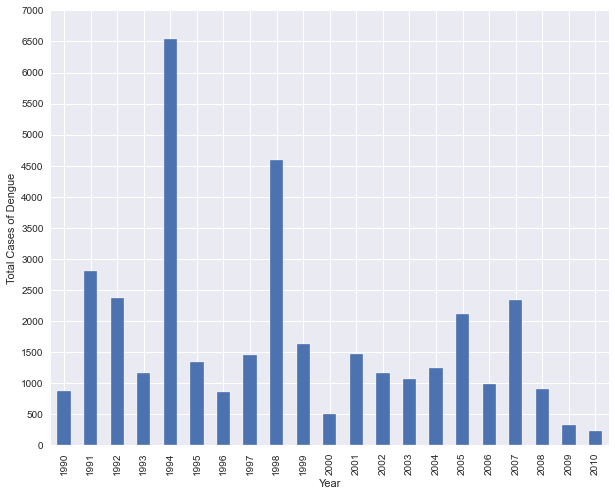

In [55]:
plt.style.use('seaborn') # Setting plot style

plt.rcParams['figure.figsize'] = [10, 8] # Setting plot size
year_max_cases = dengue_labels_train.groupby(['year'])['total_cases'].agg('sum')

#Visualizing it
year_max_cases.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Total Cases of Dengue')
plt.yticks(np.arange(0,7500, step=500))
plt.show()

So, the year 1994 faced maximum cases of Dengue

## City that has maximum cases of dengue

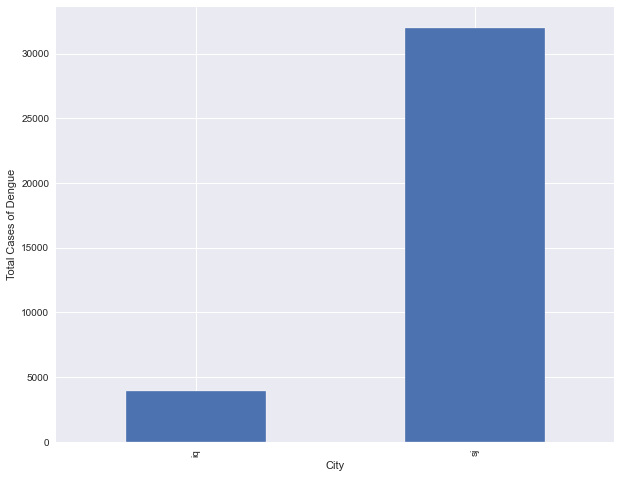

In [56]:
city_affected = dengue_labels_train.groupby(['city'])['total_cases'].agg('sum')

city_affected.plot(kind='bar')
plt.rcParams['figure.figsize'] = [5, 5]
plt.xlabel('City')
plt.ylabel('Total Cases of Dengue')
plt.show()

C:\Users\tessy\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\tessy\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.09)

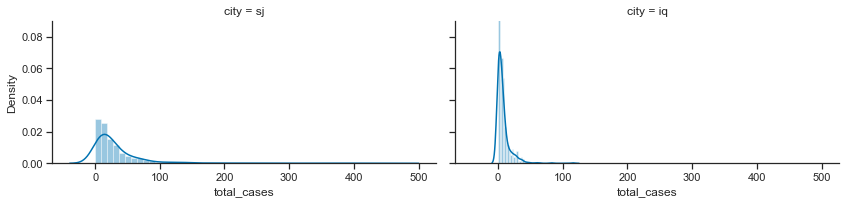

In [16]:
#Lets check the total cases of Dengue in the city's
sns.set(style="ticks", palette="colorblind")
g = sns.FacetGrid(dengue_train, col="city",aspect=2)  
g.map(sns.distplot, "total_cases") 
axes = g.axes
axes[0,0].set_ylim(0,0.090)
axes[0,1].set_ylim(0,0.090)

#### It is clear from the above that the The total cases of dengue is more in Iquitos must be higher than that of San juan for a certain period.
#### Lets see the factors also, like station_precip_mm, station_max_temp_c, station_min_temp_c and so on.

C:\Users\tessy\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\tessy\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


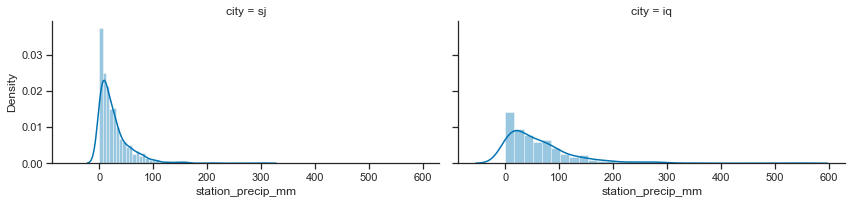

In [18]:
#Lets check the station_precip_mm in the city's
sns.set(style="ticks", palette="colorblind")
g = sns.FacetGrid(dengue_train, col="city",aspect=2)  
g.map(sns.distplot, "station_precip_mm") 

C:\Users\tessy\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\tessy\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


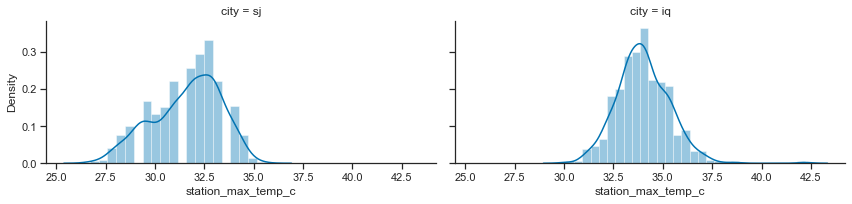

In [19]:
#Lets check the station_max_temp_c in the city's
sns.set(style="ticks", palette="colorblind")
g = sns.FacetGrid(dengue_train, col="city",aspect=2)  
g.map(sns.distplot, "station_max_temp_c") 

C:\Users\tessy\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\tessy\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


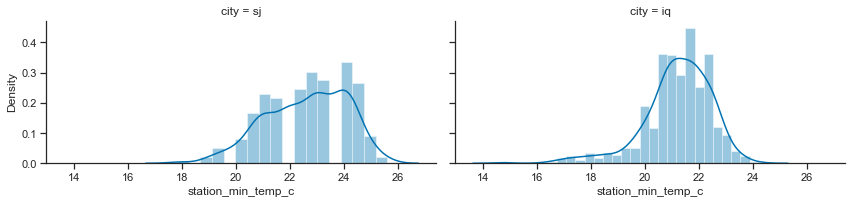

In [20]:
#Lets check the station_min_temp_c in the city's
sns.set(style="ticks", palette="colorblind")
g = sns.FacetGrid(dengue_train, col="city",aspect=2)  
g.map(sns.distplot, "station_min_temp_c") 

C:\Users\tessy\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\tessy\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


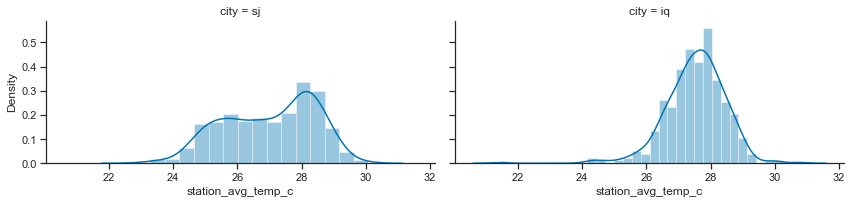

In [21]:
#Lets check the station_avg_temp_c in the city's
sns.set(style="ticks", palette="colorblind")
g = sns.FacetGrid(dengue_train, col="city",aspect=2)  
g.map(sns.distplot, "station_avg_temp_c")

#### Above plot shows that Iquitos is generally a littlbe bit hotter than San Juan,and the precipitation is much higher.
#### Which might one of the reason for more in total cases of dengue is more in Iquitos

In [23]:
dengue_train.groupby('city').mean().total_cases

city
iq     7.565385
sj    34.180556
Name: total_cases, dtype: float64

#### Surprisingly, San Juan has a lot more dengue cases than Iquitos
Now let's check the evolution of dengue disease through time

C:\Users\tessy\anaconda3\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


Text(0.5, 0.98, 'Evolution of dengue disease through time')

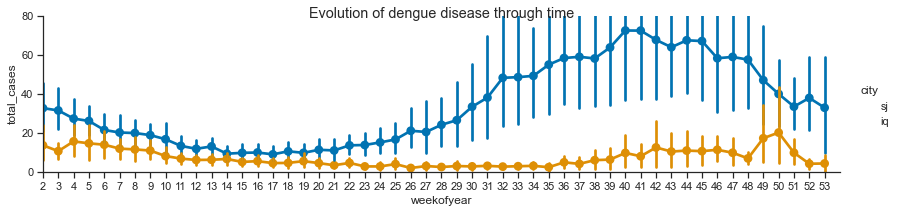

In [25]:
sns.set(style="ticks", palette="colorblind")
fig = sns.FacetGrid(dengue_train, hue='city', aspect=4) 
fig.map(sns.pointplot,'weekofyear','total_cases')
max_x = dengue_train.weekofyear.max()
min_x = dengue_train.weekofyear.min()
fig.set(xlim=(min_x,max_x))
fig.set(ylim=(0, 80))
fig.add_legend()
fig.fig.suptitle("Evolution of dengue disease through time")

#### In San Juan, one clear trend is that the dengue virus becomes a lot more active at the other half of the year, starting from July (week 28).
#### In Iquitos, the disease develop much slower, with its peak at the very end of the year (week 50).

In [27]:
#Next, let's check to see if we are missing any values in this dataset

In [28]:
#Finding the number of NUll or NaN values in the dataframe
dengue_train.isnull().sum()

city                                       0
year                                       0
weekofyear                                 0
total_cases                                0
week_start_date                            0
ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_ma

In [29]:
dengue_features_test.isnull().sum()

city                                      0
year                                      0
weekofyear                                0
week_start_date                           0
ndvi_ne                                  43
ndvi_nw                                  11
ndvi_se                                   1
ndvi_sw                                   1
precipitation_amt_mm                      2
reanalysis_air_temp_k                     2
reanalysis_avg_temp_k                     2
reanalysis_dew_point_temp_k               2
reanalysis_max_air_temp_k                 2
reanalysis_min_air_temp_k                 2
reanalysis_precip_amt_kg_per_m2           2
reanalysis_relative_humidity_percent      2
reanalysis_sat_precip_amt_mm              2
reanalysis_specific_humidity_g_per_kg     2
reanalysis_tdtr_k                         2
station_avg_temp_c                       12
station_diur_temp_rng_c                  12
station_max_temp_c                        3
station_min_temp_c              

In [30]:
#We can see there is good count NaN values present in the data to Impute the NaN values we have to notice 
#they are variables liek 'precipitation' , 'specific_humidity' and so on, which will be different fror different
#city so its wise to devide the data based on city in order to impute the missing values in the Dataset

In [31]:
#Let see the count of unique city's available 

dengue_train.city.value_counts()

sj    936
iq    520
Name: city, dtype: int64

In [32]:
#Let see the count of unique city's available 

dengue_features_test.city.value_counts()

sj    260
iq    156
Name: city, dtype: int64

In [33]:
#This dataset has two cities in it: San Juan, Puerto Rico (sj) and Iquitos, Peru (iq). 
#Since we hypothesize that the spread of dengue may follow different patterns between the two cities.
#we will divide the dataset.

In [34]:
dengue_train_sj = dengue_train[dengue_train.city == 'sj'].copy()

In [35]:
dengue_train_iq = dengue_train[dengue_train.city == 'iq'].copy()

In [36]:
dengue_test_sj = dengue_features_test[dengue_features_test.city == 'sj'].copy()
dengue_test_iq = dengue_features_test[dengue_features_test.city == 'iq'].copy()

In [37]:
dengue_train_sj.head(5)

,city,year,weekofyear,total_cases,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,4,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,5,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,4,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,3,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,6,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [38]:
dengue_train_iq.head(5)

,city,year,weekofyear,total_cases,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
936,iq,2000,26,0,2000-07-01,0.192886,0.132257,0.340886,0.247200,25.41,...,43.19,92.418571,25.41,16.651429,8.928571,26.400000,10.775000,32.5,20.7,3.0
937,iq,2000,27,0,2000-07-08,0.216833,0.276100,0.289457,0.241657,60.61,...,46.00,93.581429,60.61,16.862857,10.314286,26.900000,11.566667,34.0,20.8,55.6
938,iq,2000,28,0,2000-07-15,0.176757,0.173129,0.204114,0.128014,55.52,...,64.77,95.848571,55.52,17.120000,7.385714,26.800000,11.466667,33.0,20.7,38.1
939,iq,2000,29,0,2000-07-22,0.227729,0.145429,0.254200,0.200314,5.60,...,23.96,87.234286,5.60,14.431429,9.114286,25.766667,10.533333,31.5,14.7,30.0
940,iq,2000,30,0,2000-07-29,0.328643,0.322129,0.254371,0.361043,62.76,...,31.80,88.161429,62.76,15.444286,9.500000,26.600000,11.480000,33.3,19.1,4.0


In [44]:
dengue_train_sj.isnull().sum()

city                                     0
year                                     0
weekofyear                               0
total_cases                              0
week_start_date                          0
ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
precipitation_amt_mm                     0
reanalysis_air_temp_k                    0
reanalysis_avg_temp_k                    0
reanalysis_dew_point_temp_k              0
reanalysis_max_air_temp_k                0
reanalysis_min_air_temp_k                0
reanalysis_precip_amt_kg_per_m2          0
reanalysis_relative_humidity_percent     0
reanalysis_sat_precip_amt_mm             0
reanalysis_specific_humidity_g_per_kg    0
reanalysis_tdtr_k                        0
station_avg_temp_c                       0
station_diur_temp_rng_c                  0
station_max_temp_c                       0
station_min

In [40]:
#we'll take a simple approach and just fill those values with the most recent value that we saw up to that point. 
#This is probably a good part of the problem to improve your score by getting smarter.

#With time series data, using pad/ffill is extremely common so that the “last known value” is available at every time point.
#The ffill() function is equivalent to fillna(method='ffill') and bfill() is equivalent to fillna(method='bfill')

#fillna(method='ffill') replace NaNs by preceding values in pandas DataFrame

In [41]:
dengue_train_sj.fillna(method='ffill', inplace=True)

In [42]:
dengue_train_iq.fillna(method='ffill', inplace=True)

In [43]:
#dengue_features_test

dengue_test_sj.fillna(method='ffill', inplace=True)
dengue_test_iq.fillna(method='ffill', inplace=True)

In [45]:
dengue_train_sj.isnull().sum()

city                                     0
year                                     0
weekofyear                               0
total_cases                              0
week_start_date                          0
ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
precipitation_amt_mm                     0
reanalysis_air_temp_k                    0
reanalysis_avg_temp_k                    0
reanalysis_dew_point_temp_k              0
reanalysis_max_air_temp_k                0
reanalysis_min_air_temp_k                0
reanalysis_precip_amt_kg_per_m2          0
reanalysis_relative_humidity_percent     0
reanalysis_sat_precip_amt_mm             0
reanalysis_specific_humidity_g_per_kg    0
reanalysis_tdtr_k                        0
station_avg_temp_c                       0
station_diur_temp_rng_c                  0
station_max_temp_c                       0
station_min

In [47]:
#Which inputs strongly correlate with total_cases

# compute the correlations
sj_correlations = dengue_train_sj.corr()
iq_correlations = dengue_train_iq.corr()

In [48]:
import matplotlib.cm as cm
from matplotlib import cm
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

sj_correlations.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

C:\Users\tessy\AppData\Local\Temp\ipykernel_22092\2172592344.py:17: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  sj_correlations.style.background_gradient(cmap, axis=1)\


,year,weekofyear,total_cases,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
year,1.00,-0.07,-0.21,-0.39,-0.50,0.01,-0.08,0.04,0.19,0.19,0.02,0.18,0.11,-0.13,-0.28,0.04,0.02,0.33,-0.09,-0.28,-0.17,0.00,0.08
weekofyear,-0.07,1.00,0.29,-0.06,-0.04,-0.04,-0.07,0.24,0.57,0.55,0.57,0.51,0.57,0.25,0.31,0.24,0.58,-0.10,0.48,-0.14,0.32,0.52,0.21
total_cases,-0.21,0.29,1.00,0.00,0.06,-0.12,0.04,0.06,0.18,0.17,0.20,0.19,0.19,0.11,0.14,0.06,0.21,-0.07,0.19,0.03,0.19,0.17,0.05
ndvi_ne,-0.39,-0.06,0.00,1.00,0.61,0.21,0.16,-0.06,-0.08,-0.08,-0.05,-0.06,-0.09,-0.00,0.02,-0.06,-0.05,-0.02,0.06,0.19,0.10,0.00,-0.08
ndvi_nw,-0.50,-0.04,0.06,0.61,1.00,0.19,0.22,-0.04,-0.08,-0.08,-0.03,-0.04,-0.08,0.00,0.07,-0.04,-0.02,-0.05,0.09,0.18,0.14,0.02,-0.08
ndvi_se,0.01,-0.04,-0.12,0.21,0.19,1.00,0.80,-0.11,-0.01,-0.01,-0.06,-0.01,-0.05,-0.13,-0.12,-0.11,-0.06,0.04,-0.06,0.01,-0.08,-0.07,-0.14
ndvi_sw,-0.08,-0.07,0.04,0.16,0.22,0.80,1.00,-0.12,-0.04,-0.03,-0.08,-0.01,-0.07,-0.12,-0.11,-0.12,-0.08,0.05,-0.04,0.07,-0.01,-0.07,-0.17
precipitation_amt_mm,0.04,0.24,0.06,-0.06,-0.04,-0.11,-0.12,1.00,0.24,0.22,0.40,0.26,0.25,0.51,0.50,1.00,0.41,-0.09,0.20,-0.16,0.19,0.23,0.57
reanalysis_air_temp_k,0.19,0.57,0.18,-0.08,-0.08,-0.01,-0.04,0.24,1.00,1.00,0.90,0.94,0.94,0.08,0.30,0.24,0.91,0.18,0.88,0.04,0.70,0.83,0.12
reanalysis_avg_temp_k,0.19,0.55,0.17,-0.08,-0.08,-0.01,-0.03,0.22,1.00,1.00,0.90,0.94,0.94,0.06,0.29,0.22,0.90,0.20,0.88,0.06,0.70,0.83,0.10


In [49]:
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)
def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

iq_correlations.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

C:\Users\tessy\AppData\Local\Temp\ipykernel_22092\813122859.py:14: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  iq_correlations.style.background_gradient(cmap, axis=1)\


,year,weekofyear,total_cases,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
year,1.00,-0.14,0.18,-0.06,0.03,-0.07,-0.01,0.09,0.03,0.01,0.32,-0.16,0.22,0.16,0.25,0.09,0.32,-0.24,0.08,-0.12,0.01,0.13,-0.04
weekofyear,-0.14,1.00,-0.01,0.26,0.23,0.33,0.26,-0.10,0.29,0.30,-0.09,0.40,-0.03,-0.15,-0.28,-0.10,-0.08,0.35,0.08,0.22,0.19,-0.09,-0.05
total_cases,0.18,-0.01,1.00,0.02,-0.01,-0.04,0.03,0.09,0.10,0.08,0.23,-0.05,0.21,0.10,0.13,0.09,0.23,-0.13,0.11,-0.02,0.08,0.20,0.05
ndvi_ne,-0.06,0.26,0.02,1.00,0.76,0.77,0.84,-0.01,0.15,0.17,-0.03,0.22,-0.00,-0.08,-0.14,-0.01,-0.03,0.17,0.12,0.15,0.14,-0.01,0.01
ndvi_nw,0.03,0.23,-0.01,0.76,1.00,0.65,0.77,-0.06,0.15,0.17,-0.03,0.20,0.00,-0.08,-0.13,-0.06,-0.03,0.17,0.12,0.19,0.15,-0.09,-0.02
ndvi_se,-0.07,0.33,-0.04,0.77,0.65,1.00,0.71,-0.04,0.20,0.21,-0.06,0.26,-0.02,-0.12,-0.19,-0.04,-0.06,0.22,0.13,0.17,0.16,-0.05,0.01
ndvi_sw,-0.01,0.26,0.03,0.84,0.77,0.71,1.00,-0.02,0.16,0.18,-0.03,0.23,-0.00,-0.06,-0.14,-0.02,-0.03,0.17,0.12,0.17,0.17,-0.05,-0.00
precipitation_amt_mm,0.09,-0.10,0.09,-0.01,-0.06,-0.04,-0.02,1.00,-0.05,-0.05,0.47,-0.23,0.33,0.34,0.43,1.00,0.47,-0.38,0.13,-0.16,-0.00,0.31,0.37
reanalysis_air_temp_k,0.03,0.29,0.10,0.15,0.15,0.20,0.16,-0.05,1.00,0.97,0.15,0.75,0.41,-0.09,-0.55,-0.05,0.18,0.55,0.59,0.51,0.65,0.24,-0.14
reanalysis_avg_temp_k,0.01,0.30,0.08,0.17,0.17,0.21,0.18,-0.05,0.97,1.00,0.14,0.78,0.39,-0.11,-0.54,-0.05,0.17,0.60,0.56,0.50,0.62,0.21,-0.14


In [50]:
#Many of the temperature data are strongly correlated, which is expected.
#But the total_cases variable doesn't have many obvious strong correlations.

#Interestingly, total_cases seems to only have weak correlations with other variables for both cities

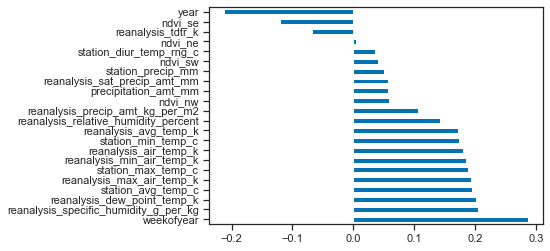

In [51]:
# San Juan
(sj_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh()
)
sns.set(style="ticks", palette="colorblind")

<AxesSubplot:>

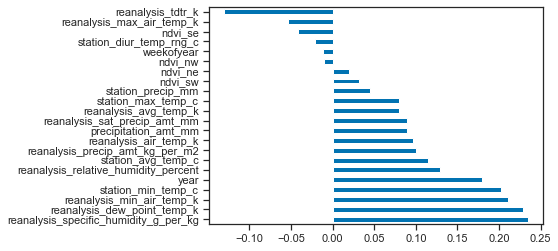

In [52]:
sns.set(style="ticks", palette="colorblind")
# iq
(iq_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh()
)

In [53]:
#The correlation strengths differ for each city, but it looks like reanalysis_specific_humidity_g_per_kg and 
#reanalysis_dew_point_temp_k are the most strongly correlated with total_cases. 
#This makes sense: we know mosquitos thrive wet climates, the wetter the better!

#A few good variables
#reanalysis_specific_humidity_g_per_kg
#reanalysis_dew_point_temp_k
#station_avg_temp_c
#station_min_temp_c

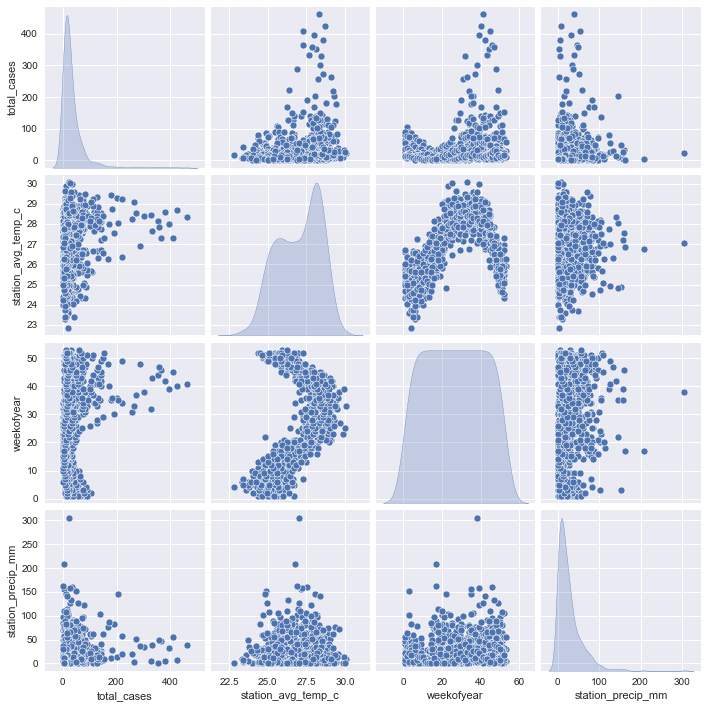

In [57]:
#Most meaningfull data
sns.pairplot(dengue_train_sj[["total_cases", "station_avg_temp_c", "weekofyear", "station_precip_mm"]], diag_kind="kde")

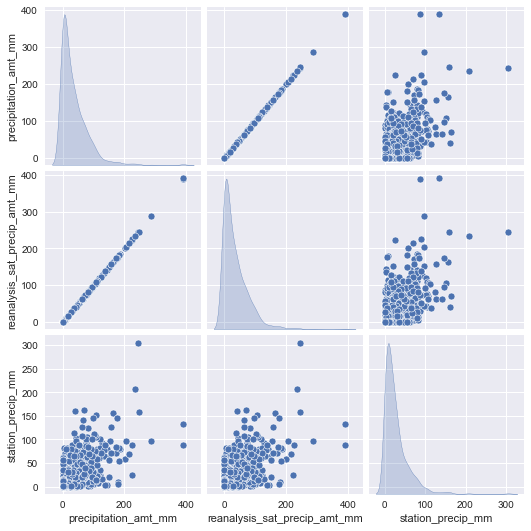

In [58]:
#Check precip dependencies
sns.pairplot(dengue_train_sj[["precipitation_amt_mm", "reanalysis_sat_precip_amt_mm", "station_precip_mm"]], diag_kind="kde")

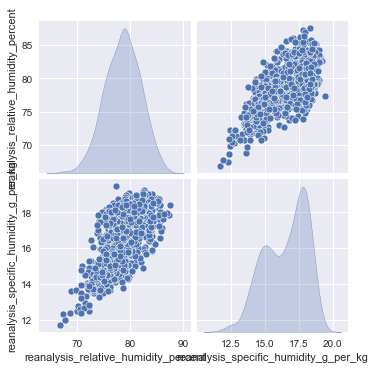

In [59]:
#Check humidity dependencies
sns.pairplot(dengue_train_sj[["reanalysis_relative_humidity_percent", "reanalysis_specific_humidity_g_per_kg"]], diag_kind="kde")

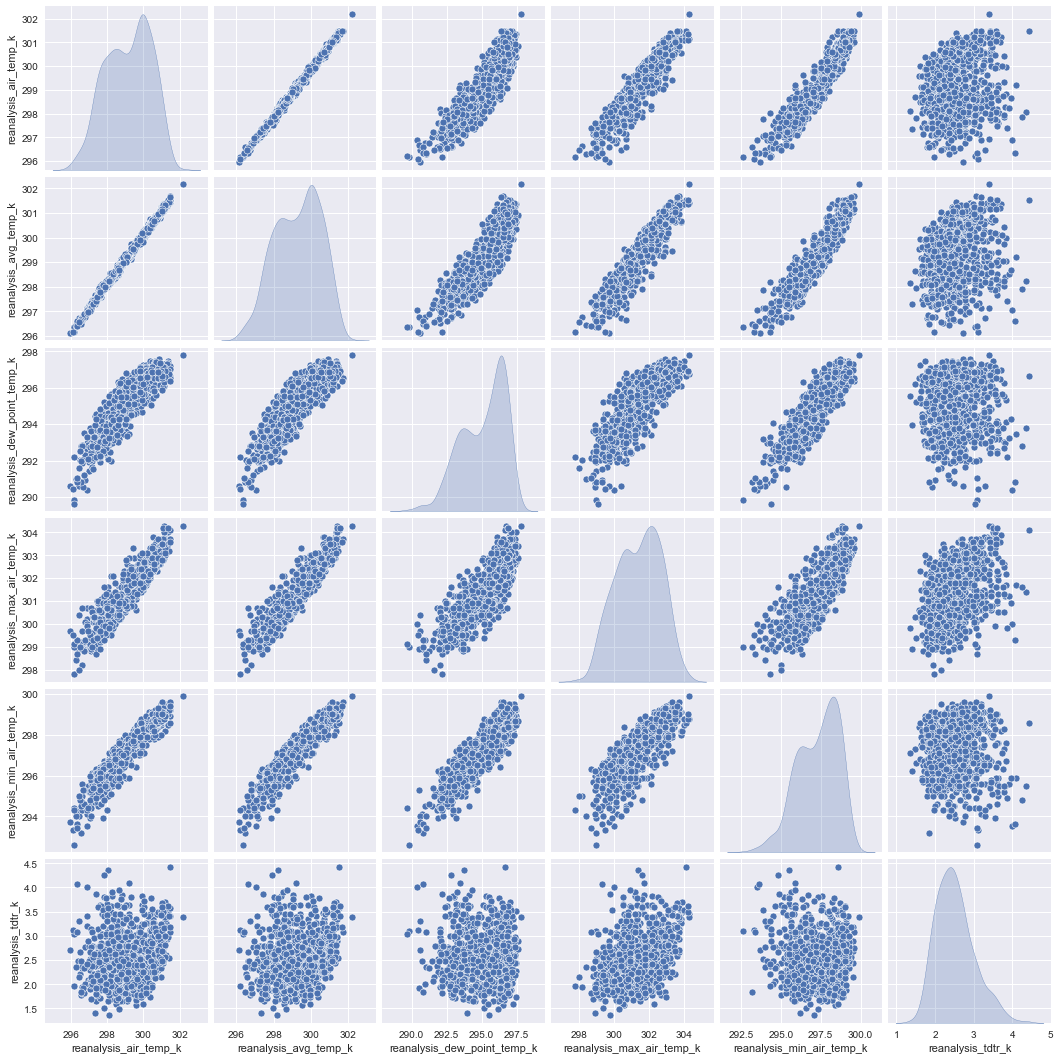

In [60]:
# Check temp dependencies
sns.pairplot(dengue_train_sj[[
    "reanalysis_air_temp_k",
    "reanalysis_avg_temp_k",
    "reanalysis_dew_point_temp_k",
    "reanalysis_max_air_temp_k",
    "reanalysis_min_air_temp_k",
    "reanalysis_tdtr_k"
]], diag_kind="kde")

<AxesSubplot:xlabel='station_avg_temp_c', ylabel='station_precip_mm'>

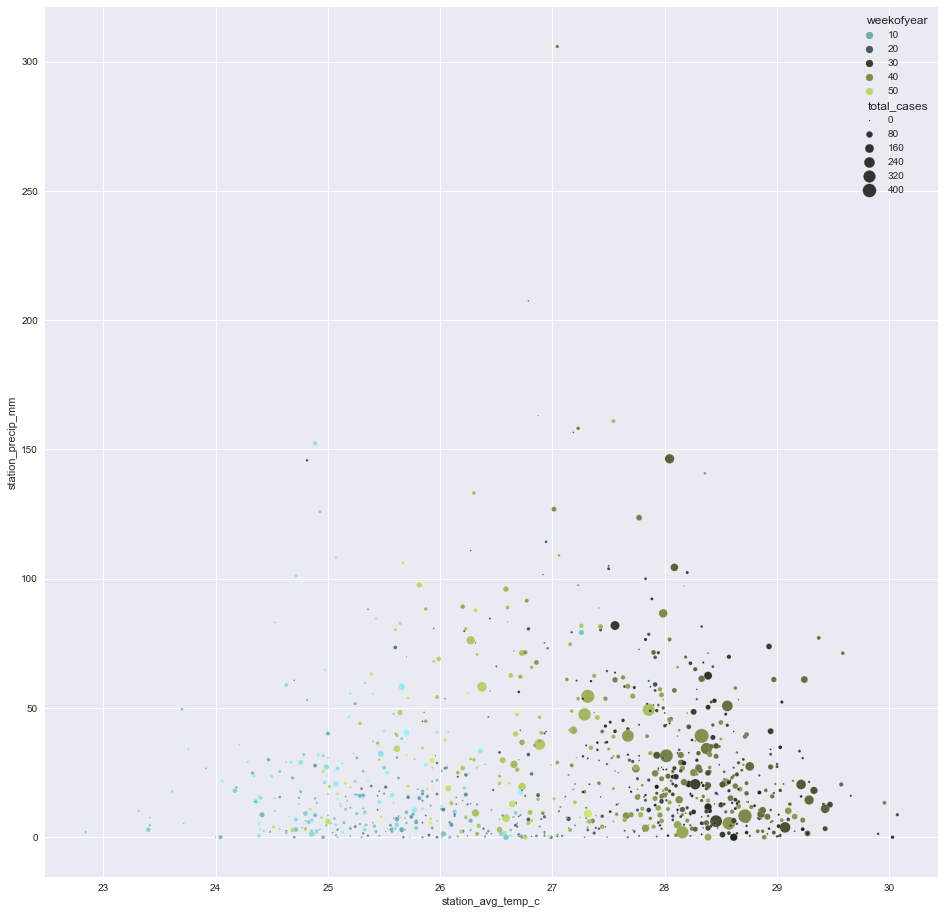

In [61]:
# Year, percip, temp for total cases dependencies
plt.figure(figsize=(16, 16))
cmap = sns.diverging_palette(200, 100, l=90, n=12, center="dark", as_cmap=True)

sns.scatterplot(palette=cmap, x="station_avg_temp_c", y="station_precip_mm", size="total_cases", sizes=(1, 200), hue="weekofyear", data=dengue_train_sj)